# Chapter 6. 금융 시계열

pandas는 금융 시계열을 분석하기에 최적인 라이브러리로  
DataFrame클래스나 Series 클래스는 금융 모델링과 분석에 있어서  
의심의 여지 없이 강력한 통계분석 언어인 R에서 착안한 것이다


이번 장에서는 Numpy, pandas로 시간 정보를 다루는 방법과 여러가지 날짜-시간 객체 유형을 상호변환하는 방법을 익힌다.

## 6-1 pandas 기초

pandas는 numpy위에서 구현되었다.
따라서 두 라이브러리를 모두 임포트하는 것으로 시작한다.

In [23]:
import numpy as np
import pandas as pd

### 6-1-1 DataFrame 클래스 다루기 1단계
DataFrame 클래스는 인덱스와 라벨이 붙어있는 자료를 다루기 위해 설계되었다.

In [132]:
# 자료: 자료 자체는 여러 가지 형태와 유형으로 주어질 수 있다.
# 라벨 : 자료는 열column로 구성되고 각 열은 이름을 가질 수 있다.
# 인텍스 : 다른 포맷(숫자, 문자열, 시간 정보 등)으로 된 인덱스가 존재한다.

df = pd.DataFrame([10, 20, 30, 40], columns=['numbers'], index=['a', 'b', 'c', 'd'])
df

,numbers
a,10
b,20
c,30
d,40


In [133]:
# DataFrame사용 예
df.index

Index(['a', 'b', 'c', 'd'], dtype='object')

In [134]:
df.columns

Index(['numbers'], dtype='object')

In [135]:
df.loc['c']

numbers    30
Name: c, dtype: int64

In [136]:
df.loc[['a', 'b']]

,numbers
a,10
b,20


In [137]:
df.loc[df.index[1:3]]

,numbers
b,20
c,30


In [138]:
df.sum()

numbers    100
dtype: int64

In [139]:
df.apply(lambda x: x ** 2)

,numbers
a,100
b,400
c,900
d,1600


In [140]:
# numpy스타일로도 가능하다
df ** 2

,numbers
a,100
b,400
c,900
d,1600


In [141]:
df['floats'] = (1.5, 2.5, 3.5, 4.5)
df

,numbers,floats
a,10,1.5
b,20,2.5
c,30,3.5
d,40,4.5


In [142]:
df['floats']

a    1.5
b    2.5
c    3.5
d    4.5
Name: floats, dtype: float64

In [143]:
# 새로운 열을 정의
df['name'] = pd.DataFrame(['Yyes', 'Guido', 'Felix', 'Francesc'], index = ['d', 'a', 'c', 'b'])
df

,numbers,floats,name
a,10,1.5,Guido
b,20,2.5,Francesc
c,30,3.5,Felix
d,40,4.5,Yyes


In [144]:
# 부적절한 경우
# 이 예제처럼 자료를 직접 넣을 경우에 자칫하면 index가 int로 바뀌기 때문에 직접넣는건 지양한다.
df.append({'numbers':100, 'floats':5.75, 'name':'Henry'}, ignore_index=True)

,numbers,floats,name
0,10,1.50,Guido
1,20,2.50,Francesc
2,30,3.50,Felix
3,40,4.50,Yyes
4,100,5.75,Henry


In [145]:
# 적절한 경우
# 적절한 인덱스 정보와 함께 DataFrame객체를 추가하는 것은 괜찮다.
df = df.append(pd.DataFrame({'numbers':100, 'floats':5.75, 'name':'Henry'}, index=['z',]))
df

,numbers,floats,name
a,10,1.50,Guido
b,20,2.50,Francesc
c,30,3.50,Felix
d,40,4.50,Yyes
z,100,5.75,Henry


pandas의 장점은 누락된 자료를 다루는 것이다.  
다음과 같이 다른 인덱스를 가진 새로운 열을 추가한다.

In [146]:
df.join(pd.DataFrame([1, 4, 9, 16, 25],
                     index=['a', 'b', 'c', 'd', 'y'],
                    columns=['squares',]))

,numbers,floats,name,squares
a,10,1.50,Guido,1.0
b,20,2.50,Francesc,4.0
c,30,3.50,Felix,9.0
d,40,4.50,Yyes,16.0
z,100,5.75,Henry,NaN


y index 도 사라지고 z값은 NaN이 생성되었다.  
이렇게 인덱스가 누락되고값도 보존하기 위해선 아래와 같이 join에 how을 넣는다.

In [147]:
df = df.join(pd.DataFrame([1, 4, 9, 16, 25],
                        index=['a', 'b', 'c', 'd', 'y'],
                        columns=['squares',]),
                        how='outer')
df

,numbers,floats,name,squares
a,10.0,1.50,Guido,1.0
b,20.0,2.50,Francesc,4.0
c,30.0,3.50,Felix,9.0
d,40.0,4.50,Yyes,16.0
y,NaN,NaN,NaN,25.0
z,100.0,5.75,Henry,NaN


누락된 자료가 있어도 대부분의 메서도 호출은 다음과 같이 정상적으로 동작한다.

In [148]:
df[['numbers', 'squares']].mean()

numbers    40.0
squares    11.0
dtype: float64

In [149]:
df[['numbers', 'squares']].std()

numbers    35.355339
squares     9.669540
dtype: float64

### 6-1-2 DataFrame 클래스 다루기 2단계


수치 자료를 이용하여 시계열 자료를 만들기 위해 DatetimeIndex와 같은 기능을 추가해보자

In [150]:
a = np.random.standard_normal((9, 4))
a.round(6)

array([[ 0.815296, -0.549747,  0.832957,  0.764093],
       [-0.739554,  0.378824, -1.51616 ,  0.218856],
       [-0.656756,  1.654496, -1.718912, -0.580231],
       [-0.456581, -0.262204, -2.178693, -0.099348],
       [ 0.781077,  1.554035, -2.239992,  0.02514 ],
       [-2.347688,  1.583358,  0.74638 ,  0.782407],
       [ 0.908997,  0.502777, -0.120299, -0.465133],
       [-0.781517,  1.090962,  1.252665, -0.380459],
       [-1.822359, -0.882699, -0.130099,  1.77199 ]])

In [151]:
df = pd.DataFrame(a)
df

,0,1,2,3
0,0.815296,-0.549747,0.832957,0.764093
1,-0.739554,0.378824,-1.516160,0.218856
2,-0.656756,1.654496,-1.718912,-0.580231
3,-0.456581,-0.262204,-2.178693,-0.099348
4,0.781077,1.554035,-2.239992,0.025140
5,-2.347688,1.583358,0.746380,0.782407
6,0.908997,0.502777,-0.120299,-0.465133
7,-0.781517,1.090962,1.252665,-0.380459
8,-1.822359,-0.882699,-0.130099,1.771990


DataFrame 함수의 인수

> data : ndarray / dict / DataFrame  
> index : Index / array-like  
> columns : Index / array-like  
> dtype : dtype, 디폴트 None  
> copy : bool, 디폴드 None

In [152]:
# 열 개수와 같은 길이의 문자열 리스트를 할당하여 열 이름을 지정할 수 있다.

df.columns = [['No1', 'No2', 'No3', 'No4']]
df

,No1,No2,No3,No4
0,0.815296,-0.549747,0.832957,0.764093
1,-0.739554,0.378824,-1.516160,0.218856
2,-0.656756,1.654496,-1.718912,-0.580231
3,-0.456581,-0.262204,-2.178693,-0.099348
4,0.781077,1.554035,-2.239992,0.025140
5,-2.347688,1.583358,0.746380,0.782407
6,0.908997,0.502777,-0.120299,-0.465133
7,-0.781517,1.090962,1.252665,-0.380459
8,-1.822359,-0.882699,-0.130099,1.771990


In [153]:
# 아래처럼 되야하는데 안된다...
# df['No2'][3]
df['No2']

,No2
0,-0.549747
1,0.378824
2,1.654496
3,-0.262204
4,1.554035
5,1.583358
6,0.502777
7,1.090962
8,-0.882699


date_range 함수의 인수 목록  
start, end, periods, freq, tz, normalize, name

freq(주기 인수)값 종류  
>B, D, M, MS, Q, QS, A, AS, H, S, U, C, W, BM, BMS, BQ, BQS, BA, BAS, T, L

In [154]:
# freq - B: 영업일 단위, M: 월 단위 주기
dates = pd.date_range('2015-1-1', periods=9, freq='M')
dates

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30'],
              dtype='datetime64[ns]', freq='M')

In [155]:
df.index = dates
df

,No1,No2,No3,No4
2015-01-31,0.815296,-0.549747,0.832957,0.764093
2015-02-28,-0.739554,0.378824,-1.516160,0.218856
2015-03-31,-0.656756,1.654496,-1.718912,-0.580231
2015-04-30,-0.456581,-0.262204,-2.178693,-0.099348
2015-05-31,0.781077,1.554035,-2.239992,0.025140
2015-06-30,-2.347688,1.583358,0.746380,0.782407
2015-07-31,0.908997,0.502777,-0.120299,-0.465133
2015-08-31,-0.781517,1.090962,1.252665,-0.380459
2015-09-30,-1.822359,-0.882699,-0.130099,1.771990


In [156]:
# np-> pandas도 가능하지만 pandas -> np도 가능하다.
np.array(df).round(6)

array([[ 0.815296, -0.549747,  0.832957,  0.764093],
       [-0.739554,  0.378824, -1.51616 ,  0.218856],
       [-0.656756,  1.654496, -1.718912, -0.580231],
       [-0.456581, -0.262204, -2.178693, -0.099348],
       [ 0.781077,  1.554035, -2.239992,  0.02514 ],
       [-2.347688,  1.583358,  0.74638 ,  0.782407],
       [ 0.908997,  0.502777, -0.120299, -0.465133],
       [-0.781517,  1.090962,  1.252665, -0.380459],
       [-1.822359, -0.882699, -0.130099,  1.77199 ]])

### 6-1-3 기초적인 분석

pandas DataFrame 클래스에도 유용한 메서드가 많다.

In [157]:
df.sum()

No1   -4.299085
No2    5.069801
No3   -5.072154
No4    2.037314
dtype: float64

In [158]:
df.mean()

No1   -0.477676
No2    0.563311
No3   -0.563573
No4    0.226368
dtype: float64

In [159]:
df.cumsum()

,No1,No2,No3,No4
2015-01-31,0.815296,-0.549747,0.832957,0.764093
2015-02-28,0.075742,-0.170923,-0.683203,0.982949
2015-03-31,-0.581013,1.483573,-2.402115,0.402718
2015-04-30,-1.037594,1.221369,-4.580808,0.303370
2015-05-31,-0.256517,2.775404,-6.820800,0.328510
2015-06-30,-2.604206,4.358762,-6.074421,1.110916
2015-07-31,-1.695209,4.861539,-6.194720,0.645783
2015-08-31,-2.476726,5.952501,-4.942055,0.265324
2015-09-30,-4.299085,5.069801,-5.072154,2.037314


In [160]:
df.describe()

,No1,No2,No3,No4
count,9.000000,9.000000,9.000000,9.000000
mean,-0.477676,0.563311,-0.563573,0.226368
std,1.155294,0.970834,1.369791,0.760833
min,-2.347688,-0.882699,-2.239992,-0.580231
25%,-0.781517,-0.262204,-1.718912,-0.380459
50%,-0.656756,0.502777,-0.130099,0.025140
75%,0.781077,1.554035,0.746380,0.764093
max,0.908997,1.654496,1.252665,1.771990


In [161]:
np.sqrt(df)

C:\Users\hklee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


,No1,No2,No3,No4
2015-01-31,0.902938,NaN,0.912665,0.874124
2015-02-28,NaN,0.615486,NaN,0.467821
2015-03-31,NaN,1.286272,NaN,NaN
2015-04-30,NaN,NaN,NaN,NaN
2015-05-31,0.883786,1.246609,NaN,0.158557
2015-06-30,NaN,1.258315,0.863933,0.884537
2015-07-31,0.953413,0.709068,NaN,NaN
2015-08-31,NaN,1.044491,1.119225,NaN
2015-09-30,NaN,NaN,NaN,1.331161


pandas는 오류를 검출하고 해당 수학 연산이 실패한 위치에 NaN값을 집어넣는 오류 내성(falut tolerance)을 가진다.
많은 경우에 불완전한 자료도 완전한 자료처럼 처리하는 것이 가능하다.

In [162]:
np.sqrt(df).sum()

C:\Users\hklee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


No1    2.740136
No2    6.160243
No3    2.895823
No4    3.716200
dtype: float64

자료를 시각화하는 것도 한 줄로 가능하다

plot의 속성값은 189page에 적혀있다.

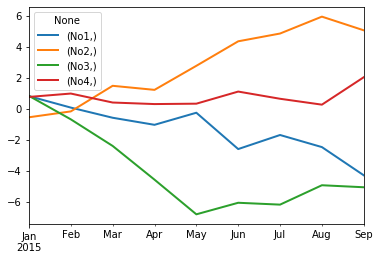

In [163]:
%matplotlib inline
df.cumsum().plot(lw=2.0)

### 6-1-4 Series 클래스

pandas에는 단일 시계열 전용의 Series 클래스도 존재한다.  
예를 들면 DataFrame 객체에서 하나의 열만 선택하면 Series 객체를 얻을 수 있다.

In [164]:
type(df)

pandas.core.frame.DataFrame

In [165]:
df['No1']

,No1
2015-01-31,0.815296
2015-02-28,-0.739554
2015-03-31,-0.656756
2015-04-30,-0.456581
2015-05-31,0.781077
2015-06-30,-2.347688
2015-07-31,0.908997
2015-08-31,-0.781517
2015-09-30,-1.822359


In [166]:
type(df['No1'])

pandas.core.frame.DataFrame

Text(0, 0.5, 'value')

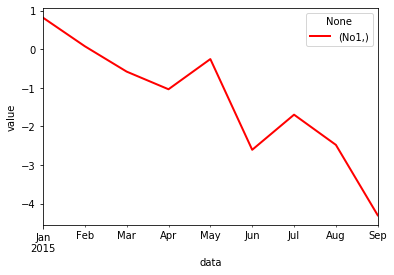

In [167]:
import matplotlib.pyplot as plt

df['No1'].cumsum().plot(style='r', lw=2.)
plt.xlabel('data')
plt.ylabel('value')

### 6-1-5 GroupBy 연산

pandas는 groupby라는 강력하고 유연한 그룹 지정 기능을 갖기고 있다.  
이 기능은 SQL의 그룹 지정 기능이나 마이크로소프트 엑셀의 피봇 테이블과 비슷하다.

In [168]:
df['Quarter'] = ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3']
df

,No1,No2,No3,No4,Quarter
2015-01-31,0.815296,-0.549747,0.832957,0.764093,Q1
2015-02-28,-0.739554,0.378824,-1.516160,0.218856,Q1
2015-03-31,-0.656756,1.654496,-1.718912,-0.580231,Q1
2015-04-30,-0.456581,-0.262204,-2.178693,-0.099348,Q2
2015-05-31,0.781077,1.554035,-2.239992,0.025140,Q2
2015-06-30,-2.347688,1.583358,0.746380,0.782407,Q2
2015-07-31,0.908997,0.502777,-0.120299,-0.465133,Q3
2015-08-31,-0.781517,1.090962,1.252665,-0.380459,Q3
2015-09-30,-1.822359,-0.882699,-0.130099,1.771990,Q3


In [172]:
# 이상하게 에러가 나옴...
# groups = df.groupby('No2')

ValueError: Grouper for 'No2' not 1-dimensional

In [173]:
# groups.mean()
# groups.max()
# groups.size()
# 193 page 생략됨

## 6-2 금융 자료

다양한 곳에서 금융 자료를 제공한다.

In [11]:
from pandas_datareader import data as web

import numpy as np

In [2]:
DAX = web.DataReader(name='^GDAXI', data_source='yahoo', start='2000-1-1')
DAX.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5074 entries, 2000-01-03 to 2020-01-02
Data columns (total 6 columns):
High         5074 non-null float64
Low          5074 non-null float64
Open         5074 non-null float64
Close        5074 non-null float64
Volume       5074 non-null float64
Adj Close    5074 non-null float64
dtypes: float64(6)
memory usage: 277.5 KB


In [3]:
DAX.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-20,13324.110352,13201.799805,13210.259766,13318.900391,170723200.0,13318.900391
2019-12-23,13331.860352,13285.549805,13304.769531,13300.980469,56215400.0,13300.980469
2019-12-27,13381.440430,13311.519531,13338.320312,13337.110352,43758600.0,13337.110352
2019-12-30,13316.620117,13244.169922,13301.429688,13249.009766,31427400.0,13249.009766
2020-01-02,13425.030273,13225.160156,13233.709961,13385.929688,0.0,13385.929688


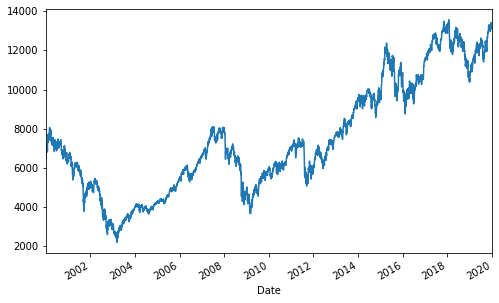

In [6]:
DAX['Close'].plot(figsize=(8, 5))

In [16]:
# 일간 종가에 기반한 로그 수익률
# 필요한 정보를 추가하는 방법은 빈 열을 만들고 매일의 자료에 대해서 로그 수익률을 하나씩 계산하는 것
# %%time
DAX['Ret_Loop'] = 0.0
for i in range(1, len(DAX)):
    DAX['Ret_Loop'][i] = np.log(DAX['Close'][i] / DAX['Close'][i - 1])

In [17]:
DAX[['Close', 'Ret_Loop']].tail()

,Close,Ret_Loop
Date,,
2019-12-20,13318.900391,0.008062
2019-12-23,13300.980469,-0.001346
2019-12-27,13337.110352,0.002713
2019-12-30,13249.009766,-0.006628
2020-01-02,13385.929688,0.010281


In [18]:
# 다른 방법으로 shift method을 이용해서 인덱스에 대해서 앞이나 뒤로 이동시키는 방법이다
# 이게 훨씬 빠르다.
%time DAX['Return'] = np.log(DAX['Close'] / DAX['Close'].shift(1))

Wall time: 30 ms


In [19]:
DAX[['Close', 'Ret_Loop', 'Return']].tail()

,Close,Ret_Loop,Return
Date,,,
2019-12-20,13318.900391,0.008062,0.008062
2019-12-23,13300.980469,-0.001346,-0.001346
2019-12-27,13337.110352,0.002713,0.002713
2019-12-30,13249.009766,-0.006628,-0.006628
2020-01-02,13385.929688,0.010281,0.010281


In [20]:
del DAX['Ret_Loop']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002983B7BE780>,
      dtype=object)

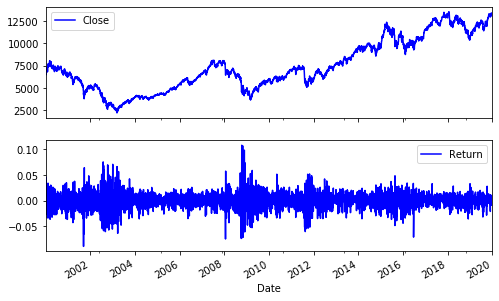

In [21]:
# 아래 차트에서 '변동성 군집현상', '레버리지 효과'를 볼 수 있다.
DAX[['Close', 'Return']].plot(subplots=True, style='b', figsize=(8, 5))

In [28]:
# 옵션 트레이더가 좋아하는 변동성보단
# 주식 트레이더가 좋아하는 이동평균선(추세선)을 구하는 방법은 아래와 같다.

# DAX['42d'] = pd.rolling_mean(DAX['Close'], window=42)
# DAX['252d'] = pd.rolling_mean(DAX['Close'], window=252)

DAX['42d'] = DAX['Close'].rolling(42).mean()
DAX['252d'] = DAX['Close'].rolling(252).mean()
DAX['500d'] = DAX['Close'].rolling(500).mean()
DAX[['Close', '42d', '252d', '500d']].tail()

,Close,42d,252d,500d
Date,,,,
2019-12-20,13318.900391,13148.434291,12069.739025,12183.947752
2019-12-23,13300.980469,13158.645740,12080.413156,12184.714434
2019-12-27,13337.110352,13169.183850,12091.140497,12185.645875
2019-12-30,13249.009766,13176.500512,12102.519465,12186.187475
2020-01-02,13385.929688,13187.126930,12113.737599,12186.623555


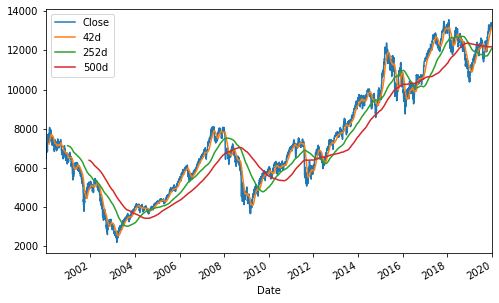

In [29]:
DAX[['Close', '42d', '252d', '500d']].plot(figsize=(8, 5))

In [38]:
# 이동 역사적 변동성이 시장이 하락하면서 증가하고
# 시장이 상승할 때는 감소하는 경향을 뚜렷이 보여줌으로써 레버리지 효과 가설을 뒷바침한다.
import math

# 이동 연간 평균선
DAX['Mov_Vol'] = DAX['Return'].rolling(252).std() * math.sqrt(252)
# DAX['Mov_Vol'] = pd.rolling_std(DAX['Return'], window=252) * math.sqrt(252)

DAX['Mov_Vol'].tail()

Date
2019-12-20    0.143470
2019-12-23    0.142657
2019-12-27    0.142663
2019-12-30    0.140660
2020-01-02    0.140057
Name: Mov_Vol, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002983CDBF5F8>,
      dtype=object)

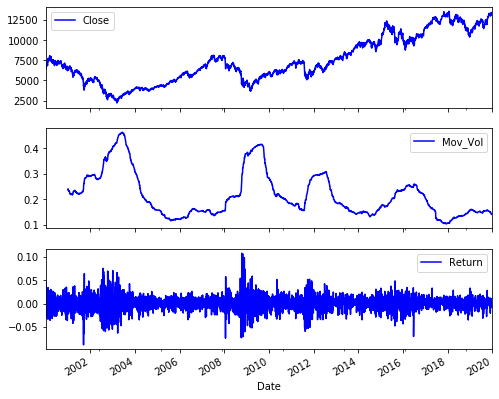

In [39]:
DAX[['Close', 'Mov_Vol', 'Return']].plot(subplots=True, style='b', figsize=(8, 7))

## 6-3 회귀분석

pandas를 이용하면 더 정식으로 통계적인 근거에 기반한 분석이 가능하다.  
가장 간단한 방법은 최소 자승법(OLS, ordinary least-squares)에 기반한 선형 회귀분석이다.

EURO STOXX 50  
유럽의 블루칩 주식으로 구성된 지수의 일간 종가 기록

VSTOXX  
유로스톡스50 지수를 기초 자산으로 하는 옵션의 내재 변동성에 기반하여 계산된 VSTOXX 변동성 지수의 일간 종가 기록

두 가지 자료를 사용해서 분석해본다

In [41]:
import pandas as pd
from urllib.request import urlretrieve

In [43]:
es_url = 'http://www.stoxx.com/download/historical_values/hbrbcpe.txt'
vs_url = 'http://www.stoxx.com/download/historical_values/h_vstoxx.txt'
urlretrieve(es_url, './data/es.txt')
urlretrieve(vs_url, './data/vs.txt')
# !ls -o ./data/*.txt

매개 변수 포맷이 틀립니다 - "data".


데이터를 import하기에 적합하게 가공해야한다.

* 임포트할 필요가 없는 헤더 라인이 몇 줄 존재한다.
* 2001년 12월 27일부터 자료의 각 줄 끝에 갑자기 세미콜론이 추가되었다.

In [45]:
lines = open('./data/es.txt', 'r').readlines()
lines = [line.replace(' ', '') for line in lines]

In [46]:
lines[:6]

['PriceIndices-EUROCurrency\n',
 'Date;Blue-Chip;Blue-Chip;Broad;Broad;ExUK;ExEuroZone;Blue-Chip;Broad\n',
 ';Europe;Euro-Zone;Europe;Euro-Zone;;;Nordic;Nordic\n',
 ';SX5P;SX5E;SXXP;SXXE;SXXF;SXXA;DK5F;DKXF\n',
 '31.12.1986;775.00;900.82;82.76;98.58;98.06;69.06;645.26;65.56\n',
 '01.01.1987;775.00;900.82;82.76;98.58;98.06;69.06;645.26;65.56\n']

In [48]:
for line in lines[3883:3890]:
    print(line[41:])

317.10;267.23;5268.36;363.19

322.55;272.18;5360.52;370.94

322.69;272.95;5360.52;370.94

327.57;277.68;5479.59;378.69;

329.94;278.87;5585.35;386.99;

326.77;272.38;5522.25;380.09;

332.62;277.08;5722.57;396.12;



자료를 정리하는 순서
1. 새로운 텍스트 파일을 생성한다.
2. 필요없는 헤더를 지운다.
3. 새 파일에 적절한 헤더를 씌운다.
4. 줄 끝의 세미콜론을 잡기 위해서 DEL이라는 보조열을 추가한다.
5. 모든 자료를 새 파일에 쓴다

In [50]:
new_file = open('./data/es50.txt', 'w')

# open new file
new_file.writelines('date' + lines[3][:-1] + ';DEL' + lines[3][-1])
new_file.writelines(lines[4:])
new_file.close()

In [51]:
new_lines = open('./data/es50.txt', 'r').readlines()
new_lines[:5]

['date;SX5P;SX5E;SXXP;SXXE;SXXF;SXXA;DK5F;DKXF;DEL\n',
 '31.12.1986;775.00;900.82;82.76;98.58;98.06;69.06;645.26;65.56\n',
 '01.01.1987;775.00;900.82;82.76;98.58;98.06;69.06;645.26;65.56\n',
 '02.01.1987;770.89;891.78;82.57;97.80;97.43;69.37;647.62;65.81\n',
 '05.01.1987;771.89;898.33;82.82;98.60;98.19;69.16;649.94;65.82\n']

In [53]:
# 데이터가 괜찮으므로 계속 진행
es = pd.read_csv('./data/es50.txt', index_col=0, parse_dates=True, sep=';', dayfirst=True)
np.round(es.tail())

,SX5P,SX5E,SXXP,SXXE,SXXF,SXXA,DK5F,DKXF,DEL
date,,,,,,,,,
2016-09-28,2847.0,2991.0,343.0,324.0,408.0,350.0,9072.0,581.0,NaN
2016-09-29,2849.0,2992.0,343.0,324.0,408.0,351.0,9112.0,583.0,NaN
2016-09-30,2843.0,3002.0,343.0,325.0,408.0,350.0,9116.0,583.0,NaN
2016-10-03,2845.0,2998.0,343.0,325.0,408.0,351.0,9131.0,584.0,NaN
2016-10-04,2871.0,3030.0,346.0,328.0,411.0,354.0,9212.0,589.0,NaN


In [54]:
# 여기에서 보조열은 삭제한다.
del es['DEL']
es.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7673 entries, 1986-12-31 to 2016-10-04
Data columns (total 8 columns):
SX5P    7673 non-null float64
SX5E    7673 non-null float64
SXXP    7673 non-null float64
SXXE    7673 non-null float64
SXXF    7673 non-null float64
SXXA    7673 non-null float64
DK5F    7673 non-null float64
DKXF    7673 non-null float64
dtypes: float64(8)
memory usage: 539.5 KB


유로 스톡스50의 자료구조에 사전정보가 있다면,  
아래와 같이 정보를 취득한다.

In [55]:
cols = ['SX5P', 'SX5E', 'SXXP' ,'SXXE', 'SXXF', 'SXXA','DK5F', 'DKXF']
es = pd.read_csv(es_url, index_col=0, parse_dates=True, sep=';', dayfirst=True, header=None, skiprows=4, names=cols)

In [56]:
es.tail()

,SX5P,SX5E,SXXP,SXXE,SXXF,SXXA,DK5F,DKXF
2016-09-28,2846.55,2991.11,342.57,324.24,407.97,350.45,9072.09,581.27
2016-09-29,2848.93,2991.58,342.72,324.08,407.65,350.90,9112.09,582.60
2016-09-30,2843.17,3002.24,342.92,325.31,408.27,350.09,9115.81,583.26
2016-10-03,2845.43,2998.50,343.23,325.08,408.44,350.92,9131.24,584.32
2016-10-04,2871.06,3029.50,346.10,327.73,411.41,353.92,9212.05,588.71


In [57]:
vs = pd.read_csv('./data/vs.txt', index_col=0, header=2, parse_dates=True, sep=',', dayfirst=True)

In [58]:
vs.tail()

,V2TX,V6I1,V6I2,V6I3,V6I4,V6I5,V6I6,V6I7,V6I8
Date,,,,,,,,,
2016-02-08,33.3917,34.7251,33.2189,31.8308,31.4783,30.6941,30.3705,29.8478,29.2559
2016-02-09,33.9664,35.7884,33.7800,32.6220,32.2459,31.5572,31.1659,30.5339,29.9000
2016-02-10,33.4528,34.6020,33.3637,32.1438,32.0018,31.2099,30.9937,30.8174,30.2533
2016-02-11,38.3051,41.2095,38.1347,35.8676,35.1073,33.7847,33.4126,32.2234,31.2124
2016-02-12,35.6846,35.3849,35.6965,34.1404,33.8645,32.9590,32.8208,32.3189,31.8194


회귀분석을 구현할 때는 각 자료에서 하나의 열만 필요하다.  
따라서 우리가 관심 있는 두 지수값을 나타내는 열을 조합하여 새로운 DataFrame객체를 만든다.

In [62]:
import datetime as dt
data = pd.DataFrame({'EUROSTOXX': es['SX5E'][es.index > dt.datetime(1999, 1, 1)]})
data = data.join(pd.DataFrame({'VSTOXX': vs['V2TX'][vs.index > dt.datetime(1999, 1, 1)]}))
data = data[data.index < '2014-09-27']

시계열에서 누락된 정보를 넣는 방법은 fillna을 사용한다.

In [63]:
data = data.fillna(method='ffill')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4034 entries, 1999-01-04 to 2014-09-26
Data columns (total 2 columns):
EUROSTOXX    4034 non-null float64
VSTOXX       4034 non-null float64
dtypes: float64(2)
memory usage: 94.5 KB


In [64]:
data.tail()

,EUROSTOXX,VSTOXX
2014-09-22,3257.48,15.8303
2014-09-23,3205.93,17.7684
2014-09-24,3244.01,15.9504
2014-09-25,3202.31,17.5658
2014-09-26,3219.58,17.6012


시각화를 통해 보면 두 지수는 음의 상관관계를 갖고 있는 것으로 보인다.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002983F6F2C50>,
      dtype=object)

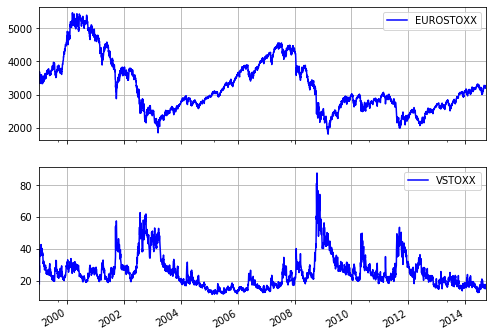

In [65]:
data.plot(subplots=True, grid=True, style='b', figsize=(8, 6))

더 정확한 분석을 위해 로그 수익률을 구해보자

In [66]:
rets = np.log(data / data.shift(1))
rets.head()

,EUROSTOXX,VSTOXX
1999-01-04,NaN,NaN
1999-01-05,0.017228,0.489248
1999-01-06,0.022138,-0.165317
1999-01-07,-0.015723,0.256337
1999-01-08,-0.003120,0.021570


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002983F315240>,
      dtype=object)

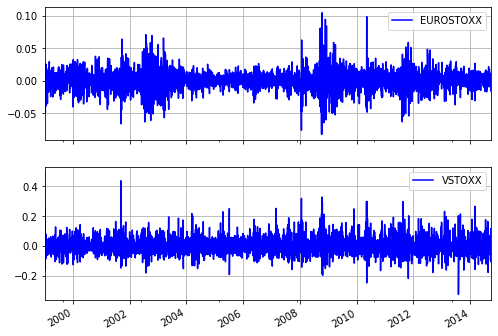

In [67]:
rets.dropna(inplace=True)
rets.plot(subplots=True, grid=True, style='b', figsize=(8, 6))

여기까지가 회귀분석을 위한 준비물이 다 갖춰진 것이다.  
유로스톡스50 수익률을 독립변수로, VSTOXX 수익률을 종속변수로 한다.

In [68]:
xdat = rets['EUROSTOXX'].values
ydat = rets['VSTOXX'].values
reg = np.polyfit(x=xdat, y=ydat, deg=1)

In [69]:
reg

array([-2.75289438e+00, -7.36991255e-05])

시각화를 하면 레버리지 효과를 강력하게 지지하는 것으로 볼 수 있다.

Text(0, 0.5, 'VSTOXX returns')

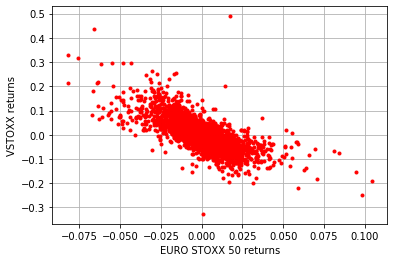

In [73]:
import matplotlib.pyplot as plt

plt.plot(xdat, ydat, 'r.')
ax = plt.axis() # grab axis values
x = np.linspace(ax[0], ax[1] + 0.01)
# plt.plot(x, model.beta[1] + model.beta[0] * x, 'b', lw=2)
plt.grid(True)
plt.axis('tight')
plt.xlabel('EURO STOXX 50 returns')
plt.ylabel('VSTOXX returns')

마지막 검증을 위해 두 시계열 값에서 직접 상관계수를 계산해본다.

In [75]:
rets.corr()

,EUROSTOXX,VSTOXX
EUROSTOXX,1.000000,-0.729538
VSTOXX,-0.729538,1.000000


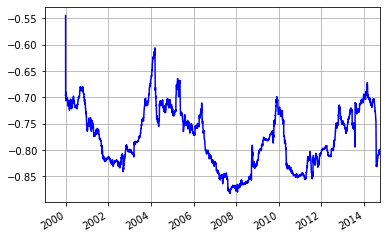

In [77]:
# 유로스톡스 50과 VSTOXX의 이동 상관계수
rets['EUROSTOXX'].rolling(252).corr(rets['VSTOXX']).plot(grid=True, style='b')